In [67]:
from triqs.plot.mpl_interface import *
from triqs.gf import *
from h5 import *
import numpy as np

In [68]:
def fuse_eo(u):
    n = len(u)
    assert n%2==0
    m = n//2
    v = np.zeros(m,dtype=type(u[0]))
    for k in range(m-1):
        v[k] = u[2*k]+u[2*k+1]
    return v

## Run

In [384]:
nid = 5
id0 = 20
ids = np.arange(id0,id0+nid,dtype=int)

files = []
files2 = []

Ns = []
Ns2 = []

beta = []
U = []
delta = []
delta0 = []

for id in ids:
    files.append(f"data/{id}test_solver.h5")
    files2.append(f"data/{id}test_solver2.h5")

    with HDFArchive(files[-1],'r') as A:
        Ns.append(A['N'])
        beta.append(A['beta'])
        U.append(A['U'])
        delta.append(A['delta'])
        delta0.append(A['delta0'])

    with HDFArchive(files2[-1],'r') as B:
        Ns2.append(B['N'])
        assert beta[-1] == B['beta']
        assert U[-1] == B['U']
        assert delta[-1] == B['delta']
        assert delta0[-1] == B['delta0']

beta = np.array(beta)
U = np.array(U)
delta = np.array(delta)
delta0 = np.array(delta0)

Ns2_m  = np.min(Ns2)
print(f"Ns\t= {Ns}")
print(f"Ns2\t= {Ns2}")
print(f"beta\t= {beta}")
print(f"U\t= {U}")
print(f"delta\t= {delta}")
print(f"delta0\t= {delta0}")

ids = ids-id0

Ns	= [10, 10, 10, 10, 10]
Ns2	= [10, 10, 10, 10, 8]
beta	= [1.2 2.4 3.6 4.8 6. ]
U	= [4 4 4 4 4]
delta	= [0.15 0.15 0.15 0.15 0.15]
delta0	= [0.5 0.5 0.5 0.5 0.5]


## Time

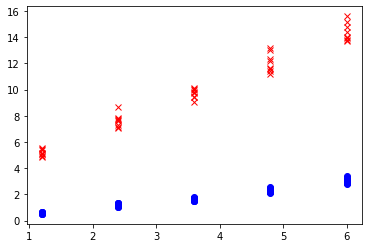

In [356]:
T = []
T2 = []
for id in ids:
    with HDFArchive(files[id],'r') as A:
        T.append(A['t'])
    with HDFArchive(files2[id],'r') as B:
        T2.append(B['t'][:Ns2_m])
plt.plot(beta,np.array(T),'bo')
plt.plot(beta,np.array(T2),'rx')
plt.show()

## Histogram

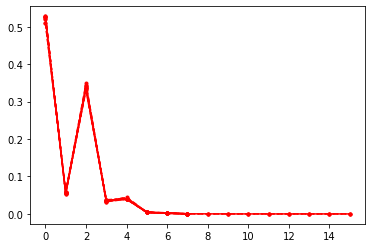

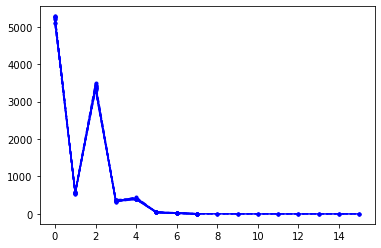

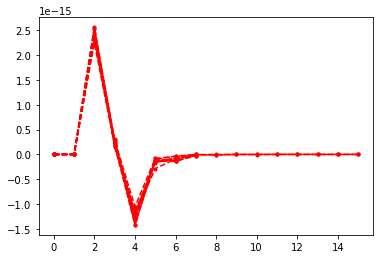

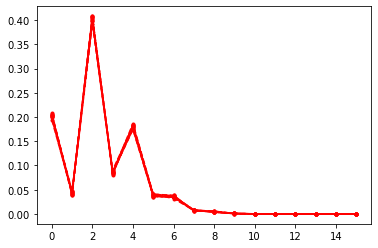

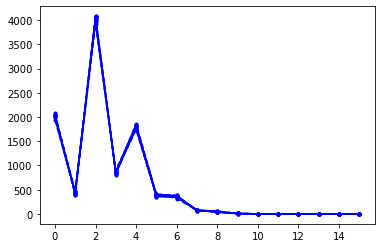

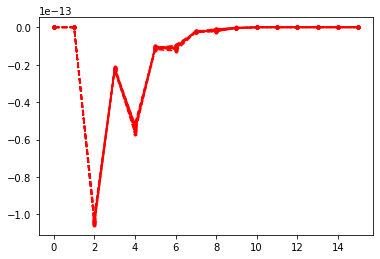

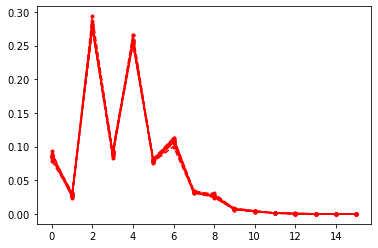

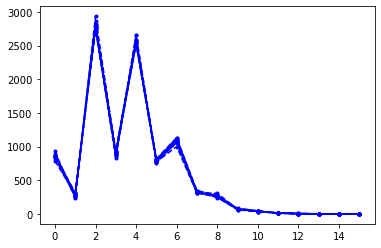

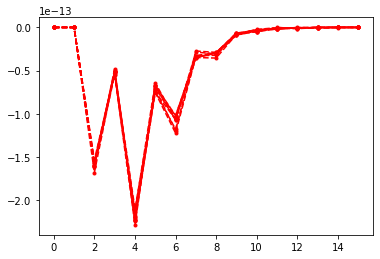

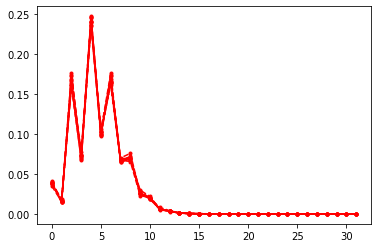

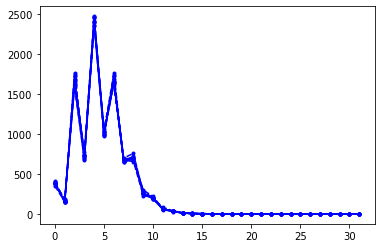

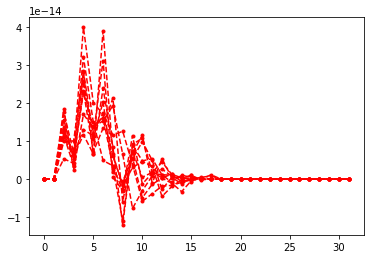

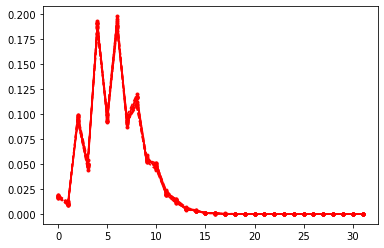

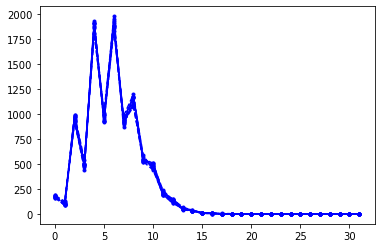

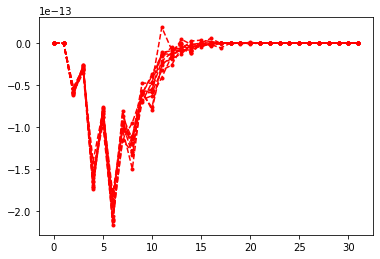

In [357]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A['hist'][i])
            k = np.arange(N)
            plt.plot(k,A['hist'][i],'r.--')
        plt.show()

        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N)
            plt.plot(k,A[f'hist_sign'][i].real,'b.--')
        plt.show()

        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N)
            plt.plot(k,A[f'hist_sign'][i].imag,'r.--')
        plt.show()

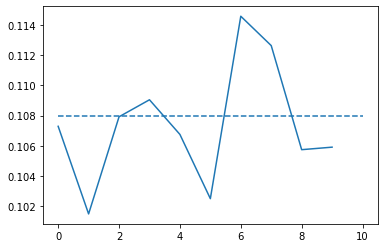

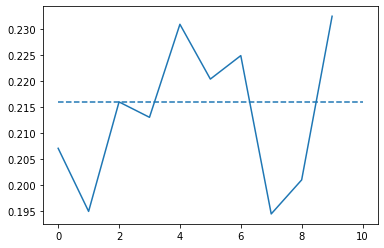

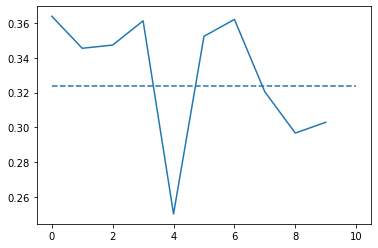

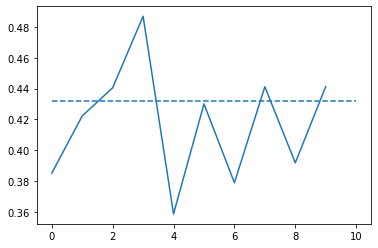

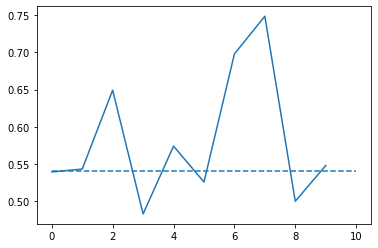

In [358]:
for id in ids:
    g = GfImFreq(beta=beta[id],indices=[0])
    mu = U[id]/2
    half_bandwidth = 1.0
    g << inverse(iOmega_n + mu - U[id]*delta0[id] - (half_bandwidth/2.0)**2 * SemiCircular(half_bandwidth) )
    n = g.density()[0,0].real
    k = np.arange(Ns[id])
    Z1 = np.zeros(Ns[id],dtype=complex)

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            Z1[i] = A[f"hist_sign"][i][1]/A[f"hist_sign"][i][0]

    plt.plot(k,Z1.real)
    Z1_th = -U[id]*beta[id]*(n-delta0[id]+delta[id])*(n-delta0[id]-delta[id])
    plt.hlines(Z1_th,0,Ns[id],linestyles='--') #,colors='g'
    plt.show()

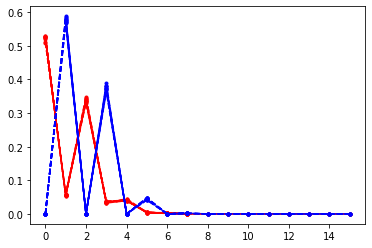

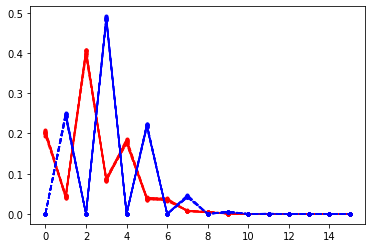

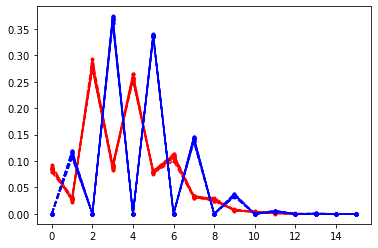

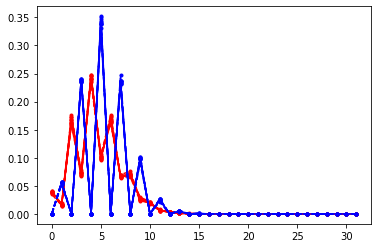

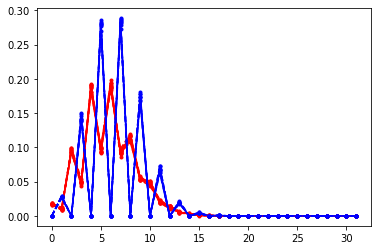

In [359]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist'][i])
            k = np.arange(N)
            plt.plot(k,A[f'hist'][i],'r.--')

    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            N = len(B[f'hist'][i])
            k = np.arange(N)
            plt.plot(k,B[f'hist'][i],'b.--')
    plt.show()

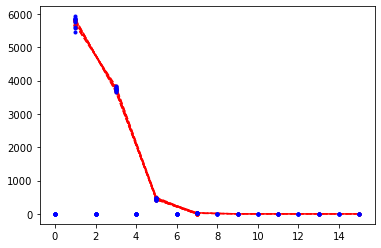

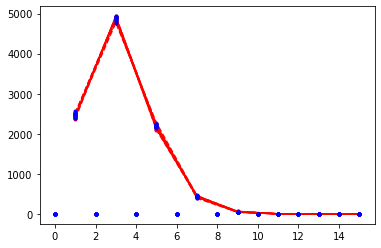

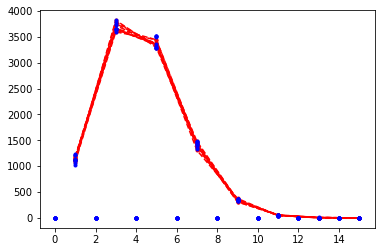

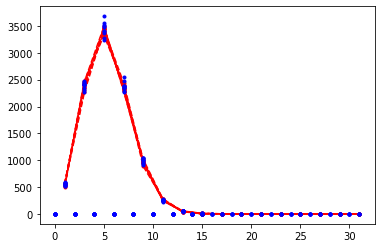

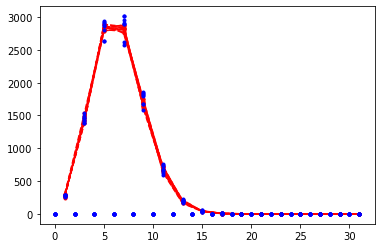

In [360]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_sign'][i])
            plt.plot(k,h.real,'r.--')

        k0 = 3
        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_sign'][i])
                k = np.arange(N)
                if B[f'hist_sign'][i][k0] != 0 and A[f'hist_sign'][i][k0-1]+A[f'hist_sign'][i][k0] != 0:
                    h = B[f'hist_sign'][i]/B[f'hist_sign'][i][k0] * (A[f'hist_sign'][i][k0]+A[f'hist_sign'][i][k0-1])
                    plt.plot(k,h.real,'b.')
                else:
                    print(f"invalid {i}")
    plt.show()

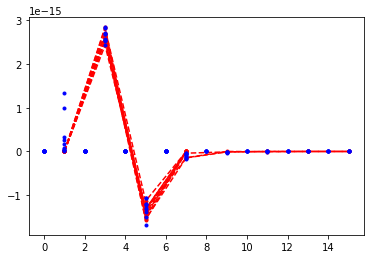

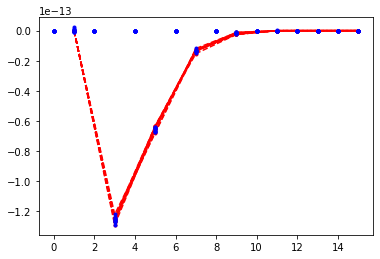

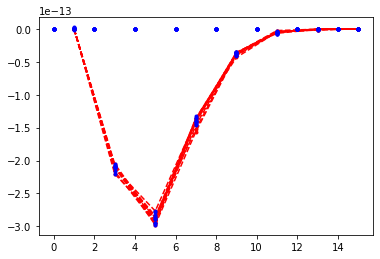

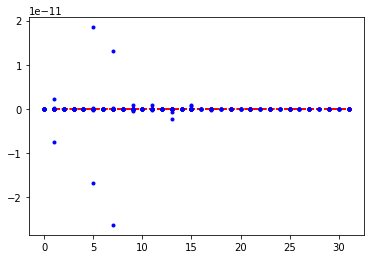

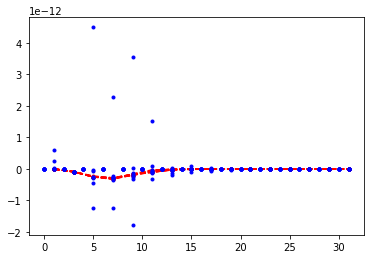

In [361]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_sign'][i])
            plt.plot(k,h.imag,'r.--')

        k0 = 3
        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_sign'][i])
                k = np.arange(N)
                if B[f'hist_sign'][i][k0] != 0 and A[f'hist_sign'][i][k0-1]+A[f'hist_sign'][i][k0] != 0:
                    h = B[f'hist_sign'][i]/B[f'hist_sign'][i][k0] * (A[f'hist_sign'][i][k0]+A[f'hist_sign'][i][k0-1])
                    plt.plot(k,h.imag,'b.')
                else:
                    print(f"invalid {i}")
    plt.show()

## Density

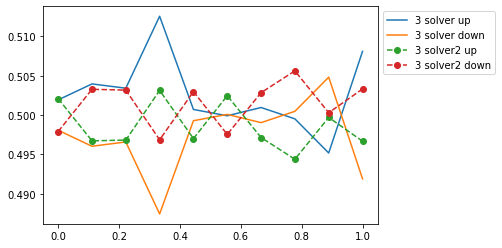

In [396]:
for id in [3]:
    k = np.linspace(0,1,Ns[id])
    n = np.zeros((Ns[id],2),dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            n[i] = A[f"n"][i]+delta0[id]
    plt.plot(k,n.real,label=[f"{id} solver up",f"{id} solver down"])

    k = np.linspace(0,1,Ns2[id])
    n2 = np.zeros((Ns2[id],2),dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            n2[i] = B[f"n"][i]+delta0[id]
    plt.plot(k,n2.real,'o--',label=[f"{id} solver2 up",f"{id} solver2 down"])

plt.legend(bbox_to_anchor=(1,1))
plt.show()

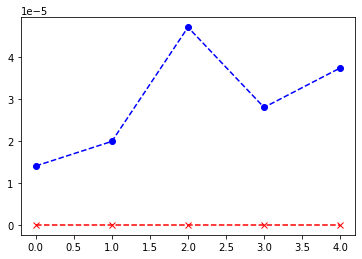

In [400]:
var = np.zeros(nid)
var2 = np.zeros(nid)

for id in ids:
    with HDFArchive(files[id],'r') as A:
            var[id] = np.array(A[f"n"]).var()
    with HDFArchive(files[id],'r') as B:
            var[id] = np.array(B[f"n"]).var()

plt.plot(ids,var,'bo--')
plt.plot(ids,var2,'rx--')
plt.show()

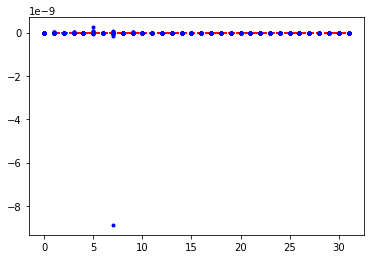

In [364]:
for id in ids:

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_n'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_n'][i])
            plt.plot(k,h.real,'r.--')

        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_n'][i])
                k = np.arange(N)
                h = B[f'hist_n'][i]
                plt.plot(k,h.real,'b.')

plt.show()

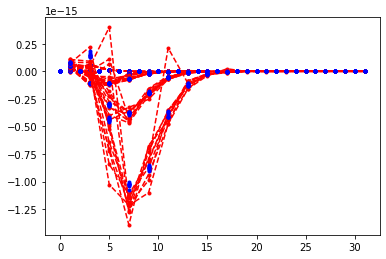

In [365]:
for id in ids:

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_n'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_n'][i])
            plt.plot(k,h.imag,'r.--')

        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_n'][i])
                k = np.arange(N)
                h = B[f'hist_n'][i]
                plt.plot(k,h.imag,'b.')

plt.show()

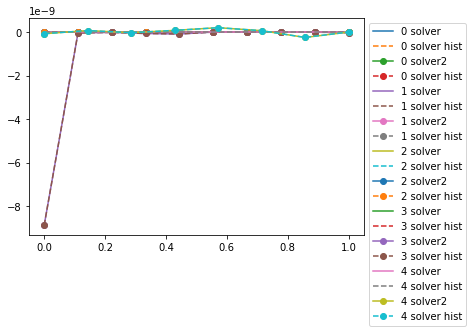

In [366]:
for id in ids:
    k = np.linspace(0,1,Ns[id])
    n = np.zeros(Ns[id],dtype=complex)
    n_hist = np.zeros(Ns[id],dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            n[i] = np.sum(A[f"n"][i])
            n_hist[i] = np.sum(A[f"hist_n"][i])
    plt.plot(k,n.real,label=f"{id} solver")
    plt.plot(k,n_hist.real,'--',label=f"{id} solver hist")

    k = np.linspace(0,1,Ns2[id])
    n2 = np.zeros(Ns2[id],dtype=complex)
    n_hist2 = np.zeros(Ns2[id],dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            n2[i] = np.sum(B[f"n"][i])
            n_hist2[i] = np.sum(B[f"hist_n"][i])
    plt.plot(k,n2.real,'o-',label=f"{id} solver2")
    plt.plot(k,n_hist2.real,'o--',label=f"{id} solver hist")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Double Occupancy

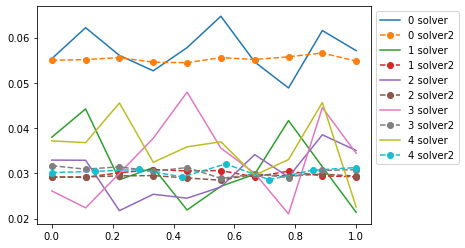

In [402]:
for id in ids:
    k = np.linspace(0,1,Ns[id])
    d = np.zeros(Ns[id],dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            d[i] = A[f"d"][i]+(delta0[id])*np.sum(A[f"n"][i])+delta0[id]**2+delta[id]**2

    #plt.hlines(d.mean().real,0,1,colors='b')
    plt.plot(k,d.real,label=f"{id} solver")

    k = np.linspace(0,1,Ns2[id])
    d2 = np.zeros(Ns2[id],dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            d2[i] = B[f"d"][i]+(delta0[id])*np.sum(B[f"n"][i])+delta0[id]**2+delta[id]**2
    #plt.hlines(d2.mean().real,0,1,linestyles='--',colors='r')
    plt.plot(k,d2.real,"o--",label=f"{id} solver2")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

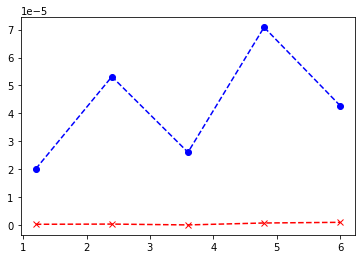

In [406]:
var = np.zeros(nid)
var2 = np.zeros(nid)

for id in ids:
    with HDFArchive(files[id],'r') as A:
            var[id] = np.array(A[f"d"]).var()
    with HDFArchive(files2[id],'r') as B:
            var2[id] = np.array(B[f"d"]).var()

plt.plot(beta,var,'bo--')
plt.plot(beta,var2,'rx--')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


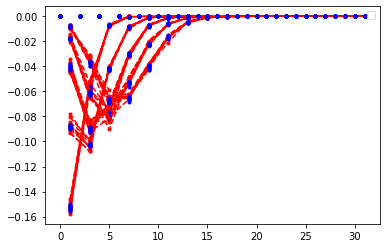

In [368]:
for id in ids:

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_d'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_d'][i])
            plt.plot(k,h.real,'r.--')

        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_d'][i])
                k = np.arange(N)
                h = B[f'hist_d'][i]
                plt.plot(k,h.real,'b.')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

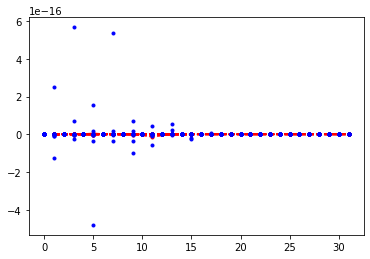

In [369]:
for id in ids:

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_d'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_d'][i])
            plt.plot(k,h.imag,'r.--')

        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_d'][i])
                k = np.arange(N)
                h = B[f'hist_d'][i]
                plt.plot(k,h.imag,'b.')
plt.show()

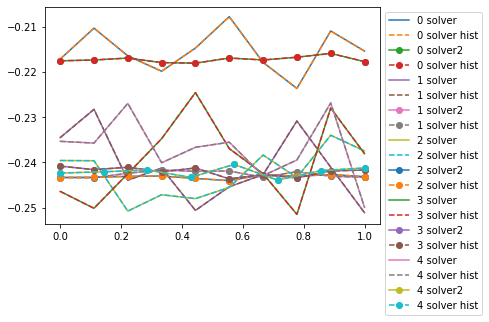

In [370]:
for id in ids:
    k = np.linspace(0,1,Ns[id])
    d = np.zeros(Ns[id],dtype=complex)
    d_hist = np.zeros(Ns[id],dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            d[i] = A[f"d"][i]
            d_hist[i] = np.sum(A[f"hist_d"][i])
    plt.plot(k,d.real,label=f"{id} solver")
    plt.plot(k,d_hist.real,'--',label=f"{id} solver hist")

    k = np.linspace(0,1,Ns2[id])
    d2 = np.zeros(Ns2[id],dtype=complex)
    d_hist2 = np.zeros(Ns2[id],dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            d2[i] = B[f"d"][i]
            d_hist2[i] = np.sum(B[f"hist_d"][i])
    plt.plot(k,d2.real,'o-',label=f"{id} solver2")
    plt.plot(k,d_hist2.real,'o--',label=f"{id} solver hist")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

## $M(i\omega_n)$

In [374]:
Nom = 10 # # of Matsubara frequencies

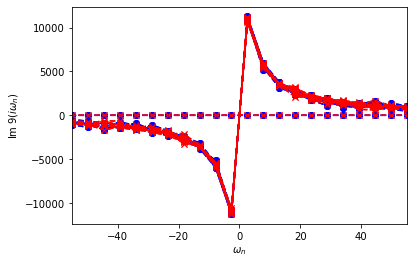

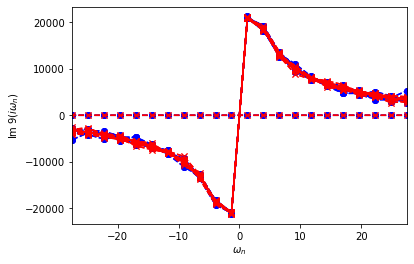

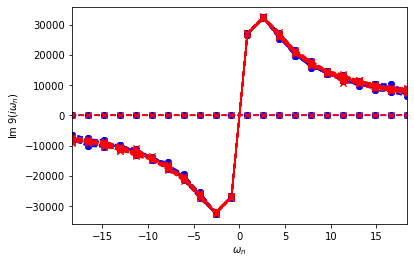

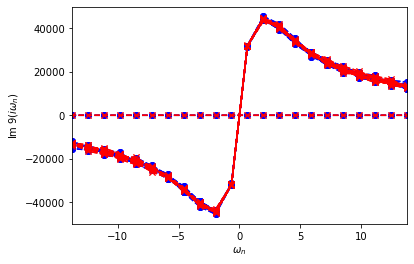

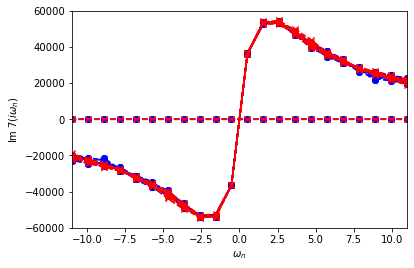

In [375]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'M_iw'][i].imag, 'bo--')

    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'M_iw'][i].imag, 'rx--')
            
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

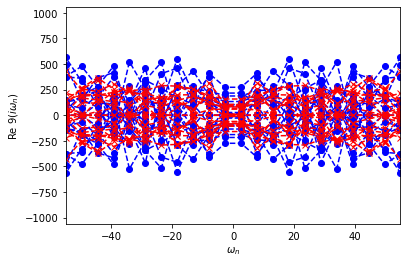

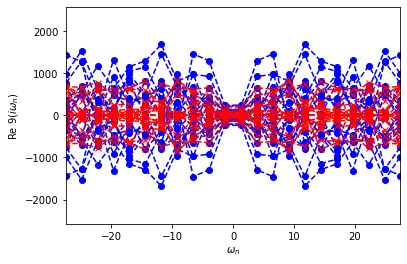

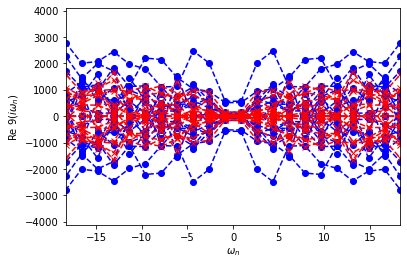

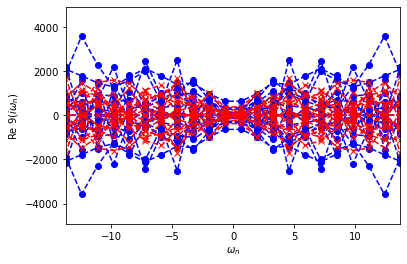

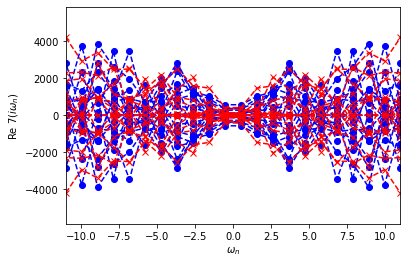

In [376]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'M_iw'][i].real, 'bo--')

    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'M_iw'][i].real, 'rx--')
            
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

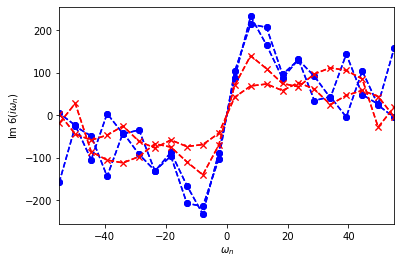

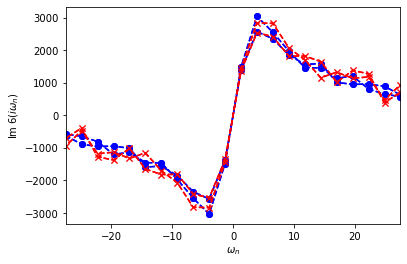

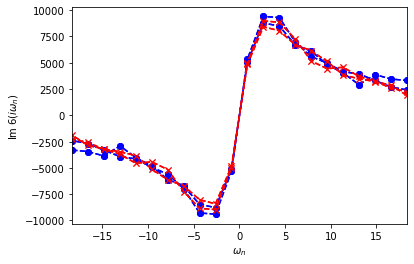

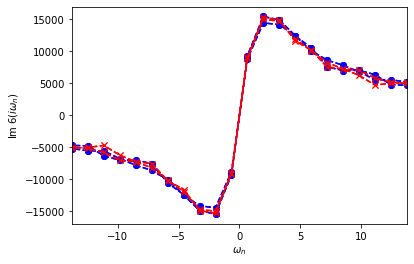

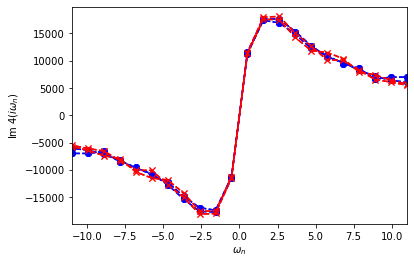

In [377]:
k0 = 5

for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            if A[f'k'][i]==k0:
                oplot(A[f'Mk_iw'][i].imag, 'bo--')
    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            if B[f'k'][i]==k0:
                oplot(B[f'Mk_iw'][i].imag, 'rx--')
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

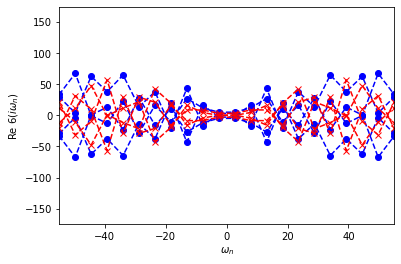

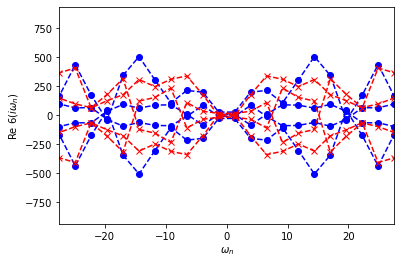

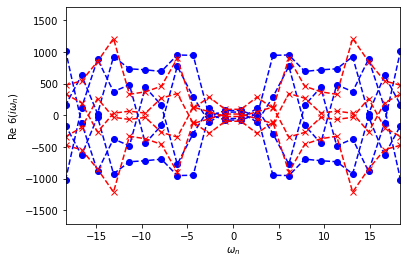

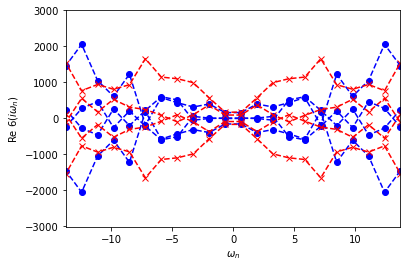

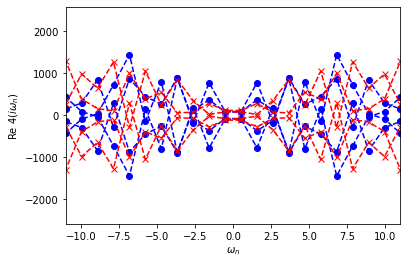

In [378]:
k0 = 5

for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            if A[f'k'][i]==k0:
                oplot(A[f'Mk_iw'][i].real, 'bo--')
    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            if B[f'k'][i]==k0:
                oplot(B[f'Mk_iw'][i].real, 'rx--')
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

## GF

In [379]:
Nom = 10 # # of Matsubara frequencies

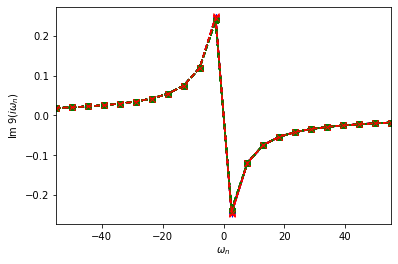

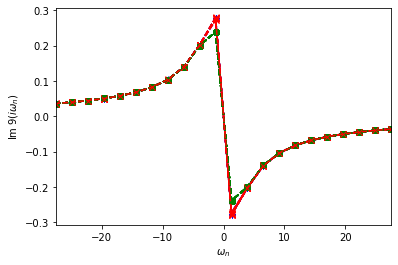

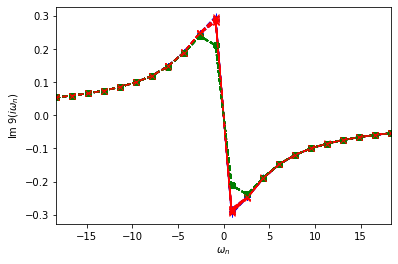

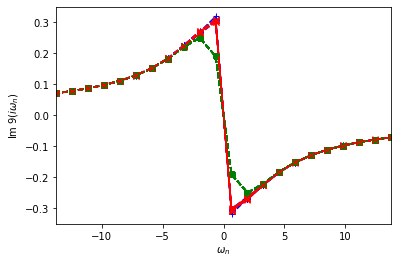

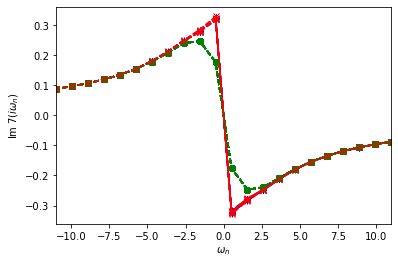

In [380]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G0_iw'][i].imag, 'go--')
            oplot(A[f'G_iw'][i].imag, 'b+--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G0_iw'][i].imag, 'go--')
            oplot(B[f'G_iw'][i].imag, 'rx--')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

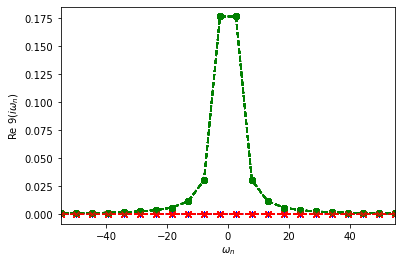

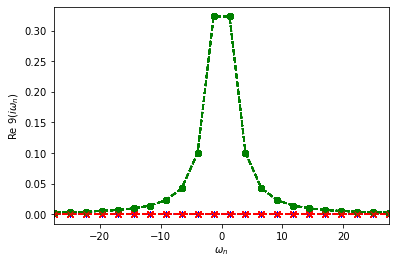

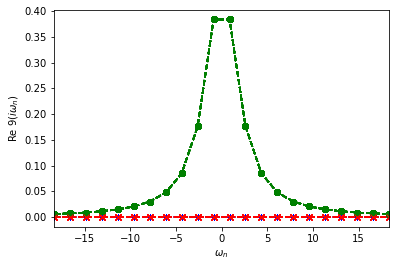

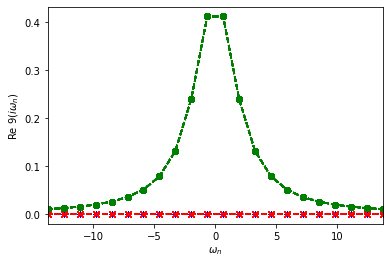

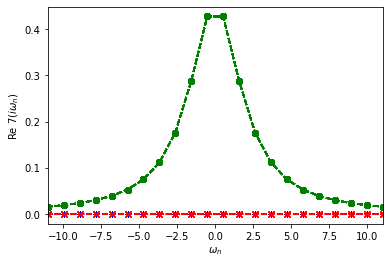

In [381]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G0_iw'][i].real, 'go--')
            oplot(A[f'G_iw'][i].real, 'b+--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G0_iw'][i].real, 'go--')
            oplot(B[f'G_iw'][i].real, 'rx--')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

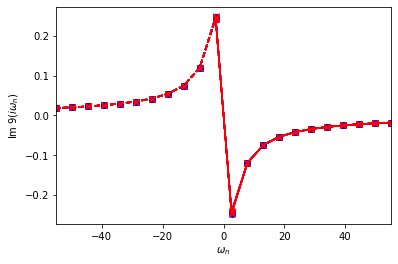

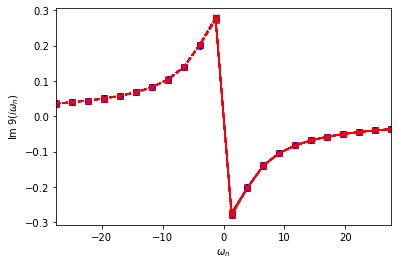

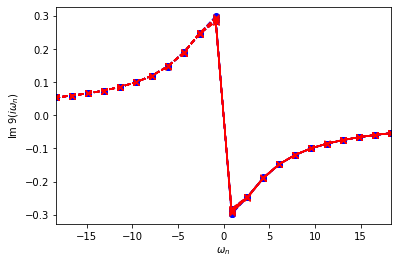

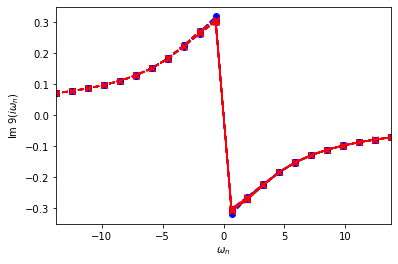

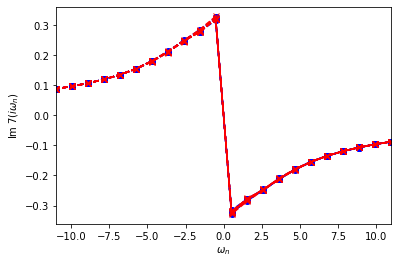

In [382]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G_iw'][i].imag, 'bo--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G_iw'][i].imag, 'rx--')

    plt.xlim(-xm,xm)

    plt.legend().remove()
    plt.show()

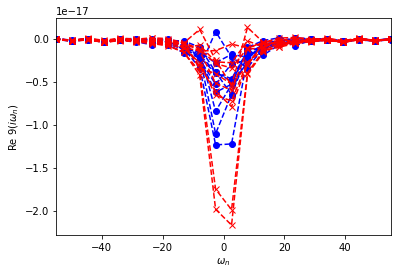

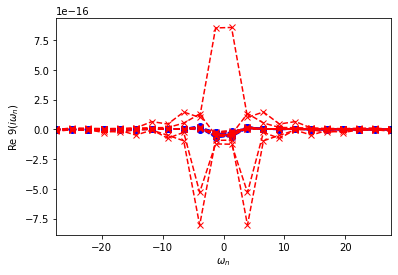

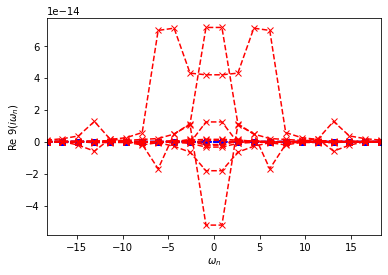

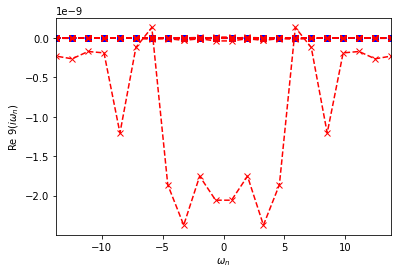

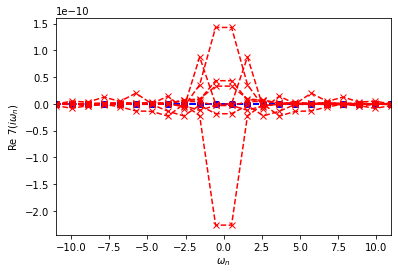

In [385]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G_iw'][i].real, 'bo--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G_iw'][i].real, 'rx--')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

## End